**Chapter_3**  
**ATMOS 6040: Environmental Statistics**  
**Alex Weech **

Download this notebook and all images and data by downloading the ZIP file from GitHub, or use the git command:

    git clone https://github.com/weech/ATMOS_5040_2019.git
    
> Note: Windows users will have to install [git for Windows](https://gitforwindows.org/) and execute the git command from the PowerShell.

# Using Julia modules
`DelimitedFiles` is a _standard library_ package that handles csv/tsv formats

`Statistics` is a _standard library_ package with some basic statistical functions

`StatsBase` is a _3rd party package_ with fancier statistical functions

`PyPlot` is a _binding_ of Python's matplotlib
`DataFrames` is a 3rd party package that lets you name columns

In [1]:
using Statistics
using Printf
using Dates
using DataFrames
using StatsBase
using Distributions
using PyPlot
using Interpolations
using HypothesisTests
import CSV

# Necessary to import local Python packages
using PyCall
pushfirst!(PyVector(pyimport("sys")["path"]), "")
@pyimport matplotlib_venn as mvenn

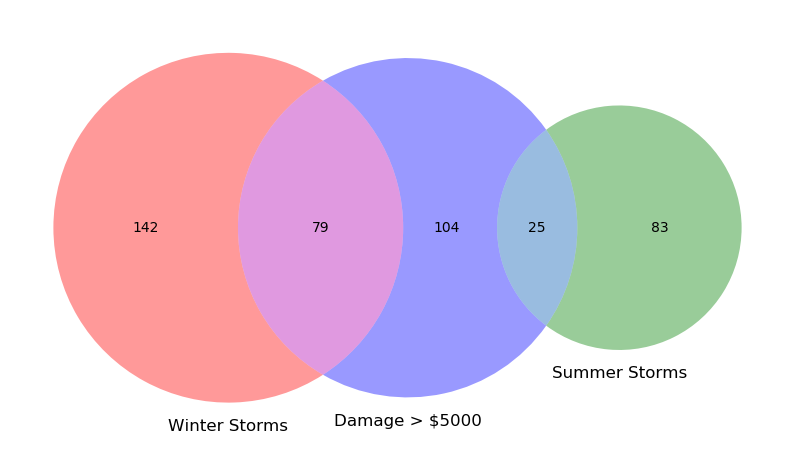

In [2]:
# Figure 3.1
figure(figsize=(10,10))
#PyPlot venn: A,B,A and B,C,A and C,B and C,A and B and C
mvenn.venn3(subsets=(142, 83, 0, 104, 79, 25, 0), set_labels=("Winter Storms", "Summer Storms", "Damage > \$5000"))
savefig("figure_3.1_2019_julia.png")

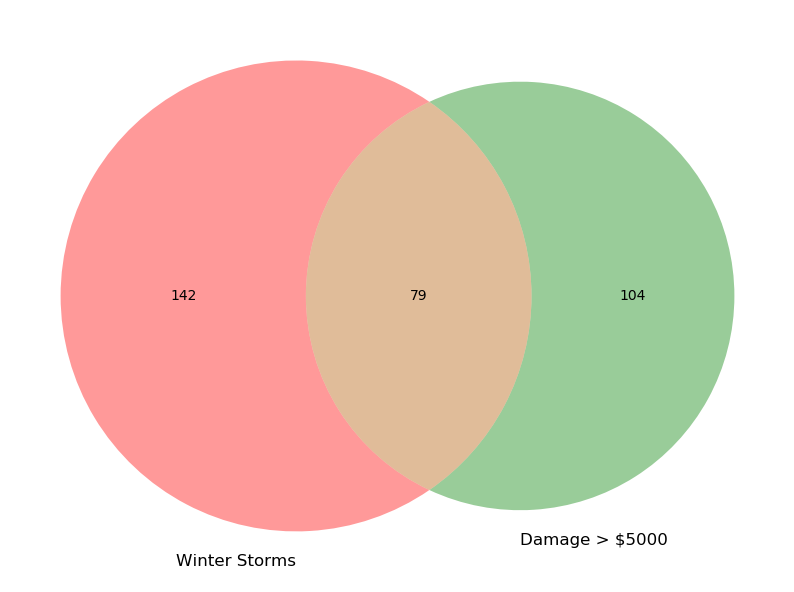

In [3]:
# Figure 3.3
figure(figsize=(10,10))
#PyPlot venn: A,B,A and B
# for demonstrating union of two types of occurrences
mvenn.venn2(subsets=(142, 104, 79), set_labels=("Winter Storms", "Damage > \$5000"))
savefig("figure_3.3_2019_julia.png")

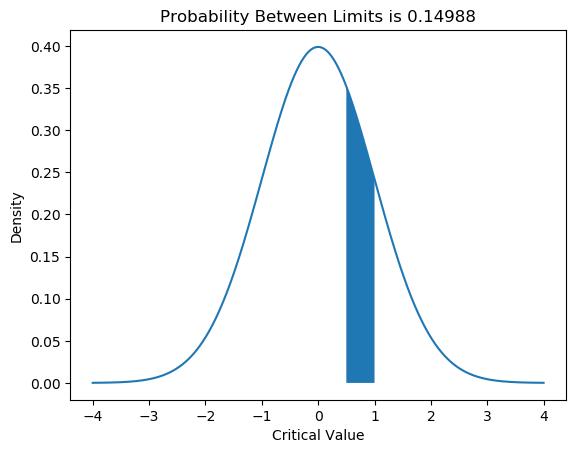

PyObject Text(24.000000000000007, 0.5, 'Density')

In [4]:
# Figure 3.5
dist = Normal(0, 1)
val = cdf(dist, 1) - cdf(dist, 0.5)
samplex = 0.5:0.01:1
fullx = -4:0.01:4
samplepdf = pdf.(dist, samplex)
fullpdf = pdf.(dist, fullx)
fill_between(samplex, samplepdf)
plot(fullx, fullpdf)
title("Probability Between Limits is $(@sprintf("%.5f", val))")
xlabel("Critical Value")
ylabel("Density")

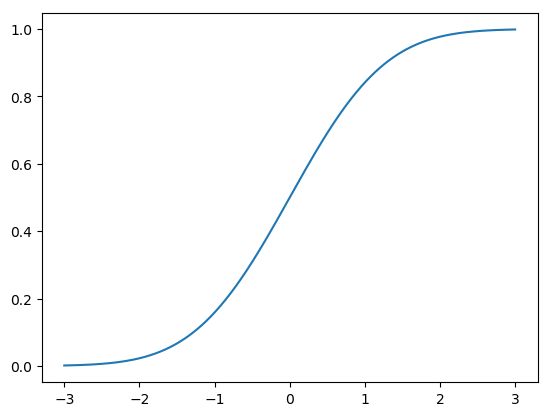

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7faa3cbe6b00>

In [5]:
# Figure 3.6
x = -3:0.01:3
plot(x, cdf.(Normal(0, 1), x))

empirical: mean and standard deviation 1279

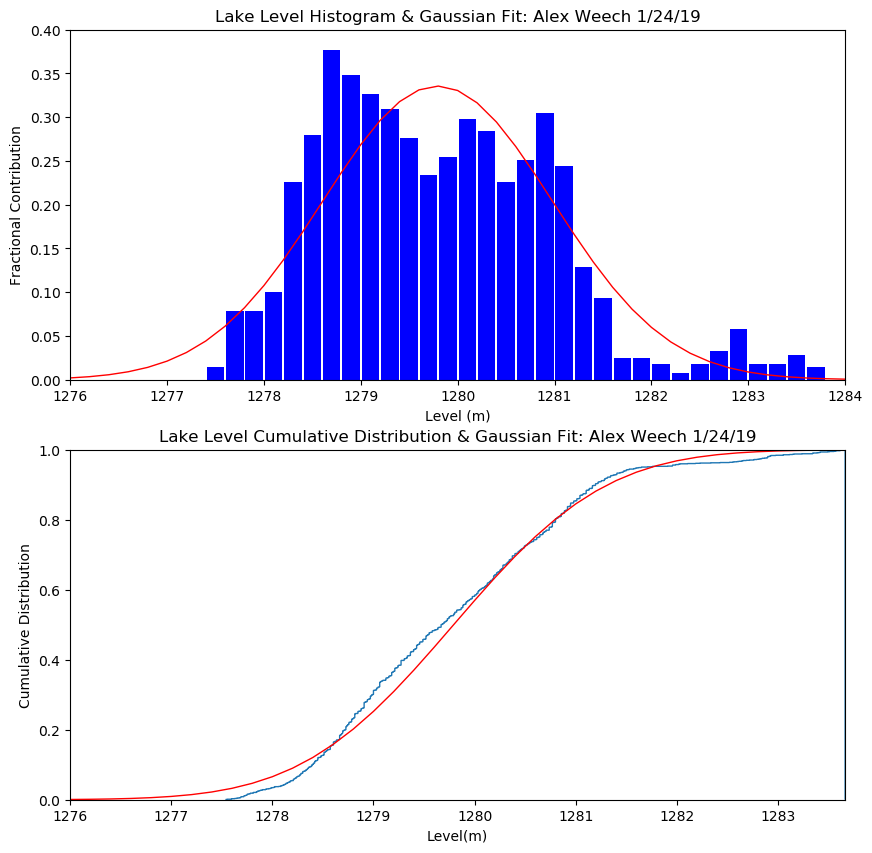

.8 1.19 (m)
gaussian fit: mean and standard deviation 1279.8 1.19 (m)


In [6]:
#figure 3.7
# plot empirical and gaussian fits to pdf and cdf of lake level

#read and then convert lake level to meters
gsl_mon = CSV.read("../data/gsl_monthly.csv", header=0)
levmon = 0.3048 * gsl_mon[:, 3]

fig2, (ax1, ax2) = subplots(2, 1, figsize=(10, 10))

#get total number of values
N = length(levmon)
#set range
x = collect(1276:0.2:1284)
#doing as fractional contributions 
#which means probability is width (0.2)* fractional contribution
_, bins, _ = ax1[:hist](levmon, x, density=true, color="blue", rwidth=0.9)
ax1[:set](xlim=(1276, 1284), ylim=(0, 0.4))
ax1[:set](xlabel="Level (m)", ylabel="Fractional Contribution")
ax1[:set_title]("Lake Level Histogram & Gaussian Fit: Alex Weech 1/24/19")

#empirical values
#mean
levm = mean(levmon)
# unbiased estimate of pop standard deviation 
stdl = std(levmon)

# gaussian fit to monthly lake level
gfit = fit(Normal, levmon)

@printf("empirical: mean and standard deviation %.1f %.2f (m)\n", levm, stdl)
@printf("gaussian fit: mean and standard deviation %.1f %.2f (m)\n", gfit.μ, gfit.σ)

# add a gaussian fit line for pdf
y1 = pdf.(gfit, bins)
ax1[:plot](bins, y1, "r", linewidth=1)

# plot the cumulative histogram
ax2[:hist](levmon, N, density="True", histtype="step", cumulative=true, label="Empirical")
ax2[:set](xlim=(1276., maximum(levmon)), ylim=(0., 1.0))
ax2[:set](xlabel="Level(m)", ylabel="Cumulative Distribution")
ax2[:set_title]("Lake Level Cumulative Distribution & Gaussian Fit: Alex Weech 1/24/19")

# add a gaussian fit line for cdf
y2 = cdf.(gfit, x)
ax2[:plot](bins, y2, "r", linewidth=1)
savefig("figure_3.3_2019_julia.png")

In [7]:
#read the collins air temperature data
fmt = DateFormat("YYmmddHH")
sitenames = [:atb, :agd, :cln, :amb, :alt]
function parsealta(line)
    vals = strip.(split(line, " "))
    vals = [v for v in vals if v != ""]
    date = DateTime(vals[1] * vals[2] * vals[3] * vals[4], fmt)
    date += ifelse(year(date) > 20, Year(1900), Year(2000))
    atb = parse(Float64, vals[5])
    agd = parse(Float64, vals[6])
    cln = parse(Float64, vals[7])
    amb = parse(Float64, vals[8])
    alt = parse(Float64, vals[9])
    return date, [atb, agd, cln, amb, alt]
end

altadata = open("../data/alta_stns.dat") do f
    df = DataFrame([DateTime, Float64, Float64, Float64, Float64, Float64], vcat(:Date, sitenames), 0)
    for line in eachline(f)
        d, s = parsealta(line)
        push!(df, (d, s...))
    end
    return df
end

,Date,atb,agd,cln,amb,alt
,DateTime,Float64,Float64,Float64,Float64,Float64
1,1998-11-25T07:00:00,-5.0,-2.8,-6.1,-7.2,-5.6
2,1998-11-25T04:00:00,-8.9,-4.4,-6.7,-8.3,-6.7
3,1998-11-25T14:00:00,-1.7,-0.6,-2.2,-6.1,-4.4
4,1998-11-30T19:00:00,6.1,6.7,1.7,-2.2,-0.6
5,1998-11-30T23:00:00,5.0,5.0,1.7,-2.2,0.0
6,1998-12-01T04:00:00,4.4,3.9,2.2,-2.2,-0.6
7,1998-12-01T05:00:00,4.4,3.9,1.7,-2.8,-1.1
8,1998-12-01T00:00:00,5.0,5.0,2.2,-1.7,0.0
9,1998-12-01T06:00:00,4.4,3.9,1.7,-2.8,-1.1


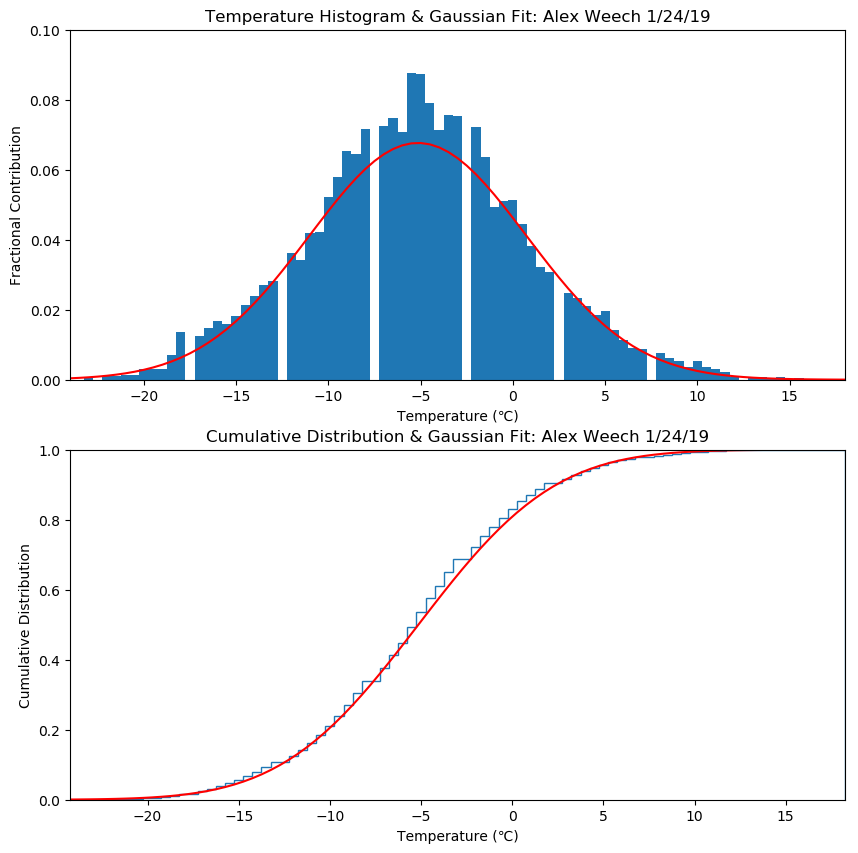

In [8]:
# Figure 3.8
# Fit gaussian to histogram of Collins temp
tm = mean(altadata.cln)
stdt = std(altadata.cln)
gfit = fit(Normal, altadata.cln)

tint = 0.5
xt = -24:tint:18
edges = vcat([x - tint/2 for x in xt], xt[end]+tint/2)

# Compute Gaussian parametric distribution
#pdfg_cln = exp.(-(xt .- gfit.μ).^2 ./ (2 .* gfit.σ)) ./ (gfit.σ .* sqrt(2*π))
pdfg_cln = pdf.(gfit, xt)

fig, (ax1, ax2) = subplots(2, 1, figsize=(10, 10))
# Since original data is at nearest whole °F, histogram has holes
ax1[:hist](altadata.cln, bins=edges, density=true)
ax1[:set_xlim](xt[1], xt[end])
ax1[:set_ylim](0, 0.1)
ax1[:plot](xt, pdfg_cln, "r")
ax1[:set_xlabel]("Temperature (℃)")
ax1[:set_ylabel]("Fractional Contribution")
ax1[:set_title]("Temperature Histogram & Gaussian Fit: Alex Weech 1/24/19")

ax2[:hist](altadata.cln, bins=edges, density=true, cumulative=true, histtype="step")
ax2[:set_xlim](edges[1], edges[end])
ax2[:set_ylim](0, 1)
ax2[:set_xlabel]("Temperature (℃)")
ax2[:set_ylabel]("Cumulative Distribution")
ax2[:set_title]("Cumulative Distribution & Gaussian Fit: Alex Weech 1/24/19")
ax2[:plot](edges, cdf.(gfit, edges), "r");

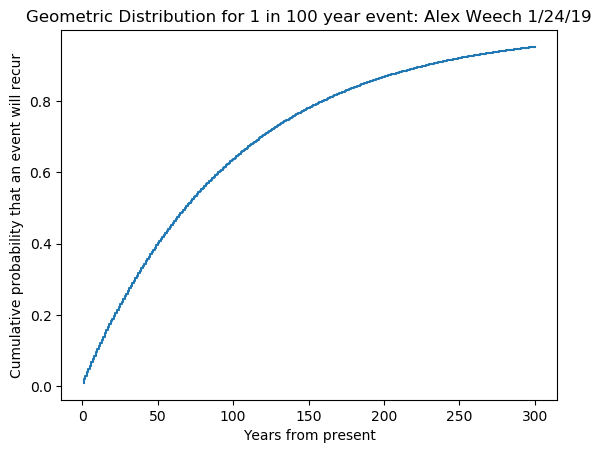

In [9]:
# Figure 3.10
xg = 300
pg = 0.01
sump = 0
cg = Vector{Float64}(undef, xg)
for i in 1:xg
    cg[i] = sump + pg * (1-pg)^(i-1)
    sump = cg[i]
end

xgg = 1:300
step(xgg, cg)
xlabel("Years from present")
ylabel("Cumulative probability that an event will recur")
title("Geometric Distribution for 1 in 100 year event: Alex Weech 1/24/19");

In [10]:
klamath = CSV.read("../data/klamath_river_streamflow.csv", types=[Int, Float64], header=[:year, :flow], allowmissing=:none)

fint = 25000
xf = 1000:fint:585000
flowm = mean(klamath.flow)
stdf = std(klamath.flow)
gfit = fit(Normal, klamath.flow)
pdfg_flow = pdf.(gfit, xf);

In [11]:
@pyimport scipy.stats as pystats
shape, loc, scale = pystats.weibull_min[:fit](klamath.flow, floc=0)
weib = Weibull(shape, scale)
pdfw_flow = pdf.(weib, xf);

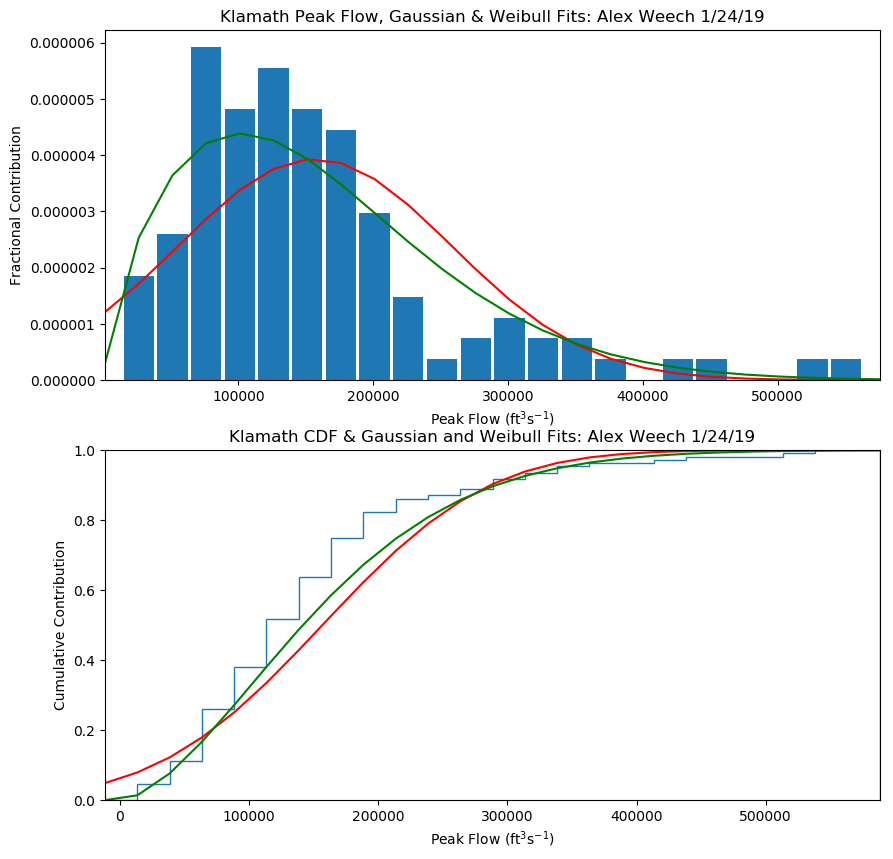

In [12]:
# Figure 3.12 (Differs from matlab due to how distributions are defined and areas are calculated)
fig, (ax1, ax2) = subplots(2, 1, figsize=(10, 10))
edges = vcat([x - fint/2 for x in xf], xf[end]+fint/2)
ax1[:hist](klamath.flow, bins=edges, density=true, rwidth=0.9)
ax1[:set_xlim](xf[1], xf[end])
#ax1[:set_ylim](0, 0.25)
ax1[:plot](xf, pdfg_flow, "r")
ax1[:plot](xf, pdfw_flow, "g")
ax1[:set_xlabel](L"Peak Flow ($\mathrm{ft}^3 \mathrm{s}^{-1}$)")
ax1[:set_ylabel]("Fractional Contribution")
ax1[:set_title]("Klamath Peak Flow, Gaussian & Weibull Fits: Alex Weech 1/24/19")

cf, _, _ = ax2[:hist](klamath.flow, bins=edges, density=true, cumulative=true, histtype="step")
ax2[:set_xlim](edges[1], edges[end])
ax2[:set_ylim](0, 1)
ax2[:plot](edges, cdf.(gfit, edges), "r")
ax2[:plot](edges, cdf.(weib, edges), "g")
ax2[:set_xlabel](L"Peak Flow ($\mathrm{ft}^3 \mathrm{s}^{-1}$)")
ax2[:set_ylabel]("Cumulative Contribution")
ax2[:set_title]("Klamath CDF & Gaussian and Weibull Fits: Alex Weech 1/24/19");

## Create quantile-quantile plot for weibull for klamath flow
see Wilks

In [13]:
cdfw = 0.001:0.001:0.999
# Compute quantile values fora  weibull fit to the data
qw = quantile.(weib, cdfw)

# Guestimate the empirical CDF (not using the ecdf function)
flows = sort(klamath.flow)
lth = length(flows)
id = 1:lth
# This is called the median estimate of the empirical CDF
medest = (id .- 0.3) ./ (lth + 0.4)
# Now compute the quantile values for the empirical CDF
qe = scale * (-log.(1 .- medest)).^(1 / shape);

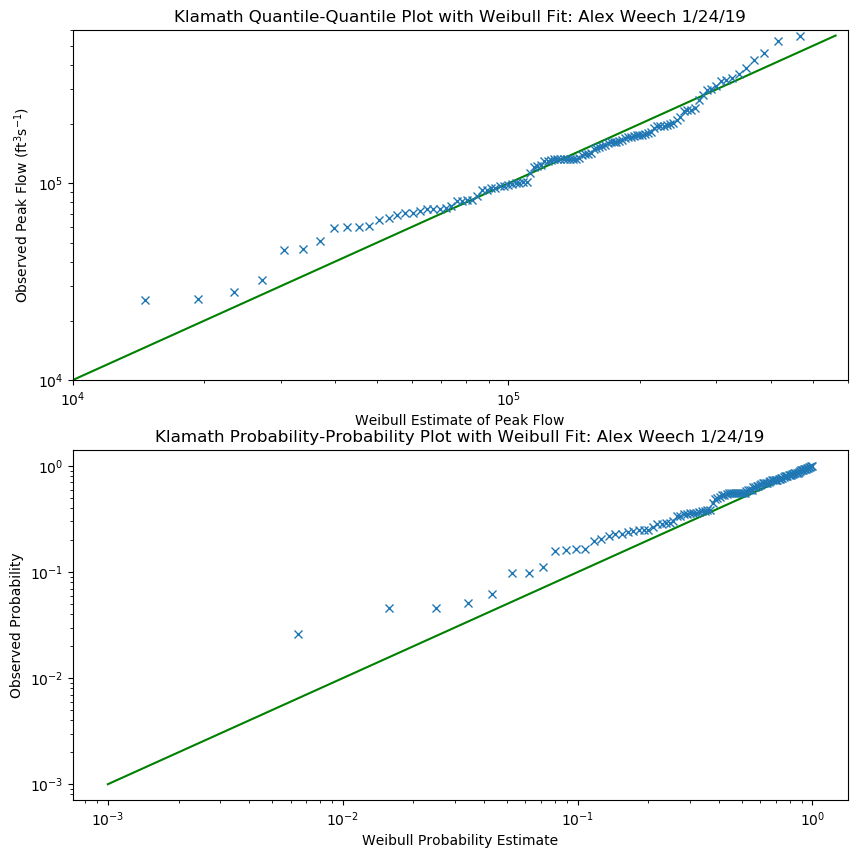

PyObject Text(0.5, 1.0, 'Klamath Probability-Probability Plot with Weibull Fit: Alex Weech 1/24/19')

In [14]:
# Figure 13
fig, (ax1, ax2) = subplots(2, 1, figsize=(10, 10))
ax1[:loglog](qw, qw, "g")
ax1[:loglog](qe, flows, "x")
ax1[:set_xlim](10000, 600000)
ax1[:set_ylim](10000, 600000)
ax1[:set_xlabel]("Weibull Estimate of Peak Flow")
ax1[:set_ylabel](L"Observed Peak Flow ($\mathrm{ft}^3 \mathrm{s}^{-1}$)")
ax1[:set_title]("Klamath Quantile-Quantile Plot with Weibull Fit: Alex Weech 1/24/19")

ax2[:loglog](cdfw, cdfw, "g")
opc = LinearInterpolation(xf, cf).(flows)
ax2[:loglog](medest, opc, "x")
ax2[:set_xlabel]("Weibull Probability Estimate")
ax2[:set_ylabel]("Observed Probability")
ax2[:set_title]("Klamath Probability-Probability Plot with Weibull Fit: Alex Weech 1/24/19")

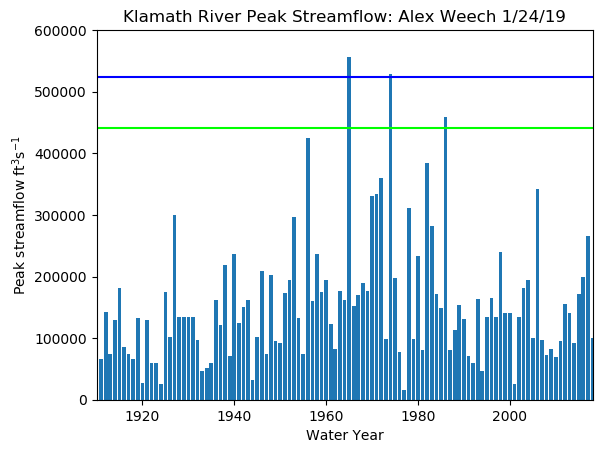

PyObject <matplotlib.collections.LineCollection object at 0x7faa386063c8>

In [15]:
# Figure 11
bar(klamath.year, klamath.flow)
xlim(1910, 2018)
ylim(0, 600000)
xlabel("Water Year")
ylabel(L"Peak streamflow $\mathrm{ft}^3 \mathrm{s}^{-1}$")
title("Klamath River Peak Streamflow: Alex Weech 1/24/19")

# Add some guestimates for one in a hundred year floods
qw99 = scale * (-log(1-0.99))^(1/shape)
hlines(qw99, 1910, 2018, color=[0, 1, 0])
emp99 = LinearInterpolation(cf, xf)(0.99)
hlines(emp99, 1910, 2018, color=[0, 0, 1])

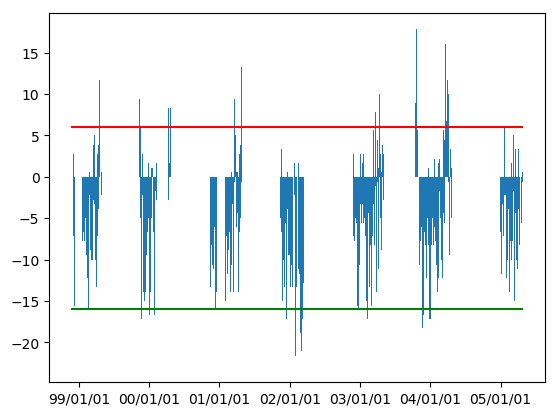

In [16]:
# Figure 3.15
@pyimport matplotlib.dates as mdates
dates = altadata.Date
x1 = [dates[1], dates[end]]
y1 = [6, 6]
y2 = [-16, -16]
plot(x1, y1, "r")
plot(x1, y2, "g")
dfmt = mdates.DateFormatter("%y/%m/%d")
gca()[:xaxis][:set_major_formatter](dfmt)
bar(dates, altadata.cln);

In [17]:
# Annual total Utah precip (cm)
ut_ppt = CSV.read("../data/utah_precip.csv", header=0, allowmissing=:none)
ppt = ut_ppt[:, 2] * 2.54
p_yr = ut_ppt[:, 1]
no_p = length(ppt)
meanp = mean(ppt)
sdp = std(ppt, corrected=false)
anomp = ppt .- meanp;

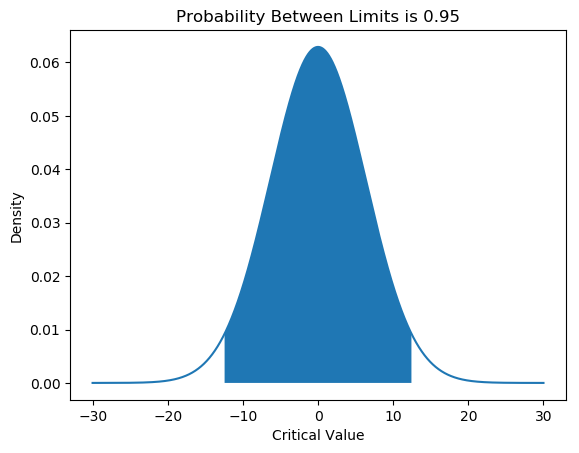

PyObject Text(24.000000000000007, 0.5, 'Density')

In [18]:
dist = Normal(0, sdp)
p_1yr_5percent = cdf(dist, 1.96*sdp) - cdf(dist, -1.96*sdp)
samplex = (-1.96*sdp):0.01:(1.96*sdp)
fullx = -30:0.01:30
samplepdf = pdf.(dist, samplex)
fullpdf = pdf.(dist, fullx)
fill_between(samplex, samplepdf)
plot(fullx, fullpdf)
title("Probability Between Limits is $(@sprintf("%.2f", p_1yr_5percent))")
xlabel("Critical Value")
ylabel("Density")

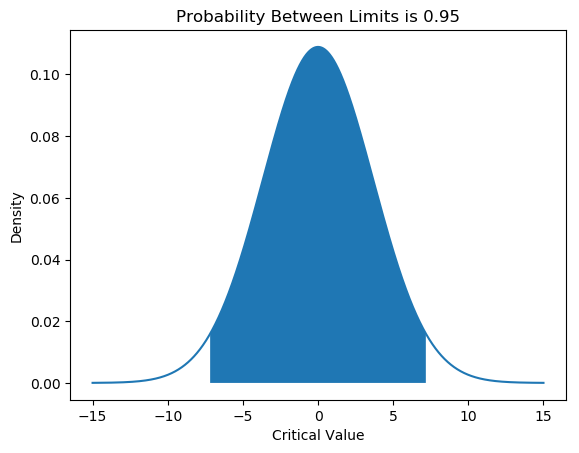

PyObject Text(24.000000000000007, 0.5, 'Density')

In [19]:
sd3 = sdp / sqrt(3)
dist3 = Normal(0, sd3)
p_3yr_5percent = cdf(dist3, 1.96*sd3) - cdf(dist3, -1.96*sd3)
samplex = (-1.96*sd3):0.01:(1.96*sd3)
fullx = -15:0.01:15
samplepdf = pdf.(dist3, samplex)
fullpdf = pdf.(dist3, fullx)
fill_between(samplex, samplepdf)
plot(fullx, fullpdf)
title("Probability Between Limits is $(@sprintf("%.2f", p_3yr_5percent))")
xlabel("Critical Value")
ylabel("Density")

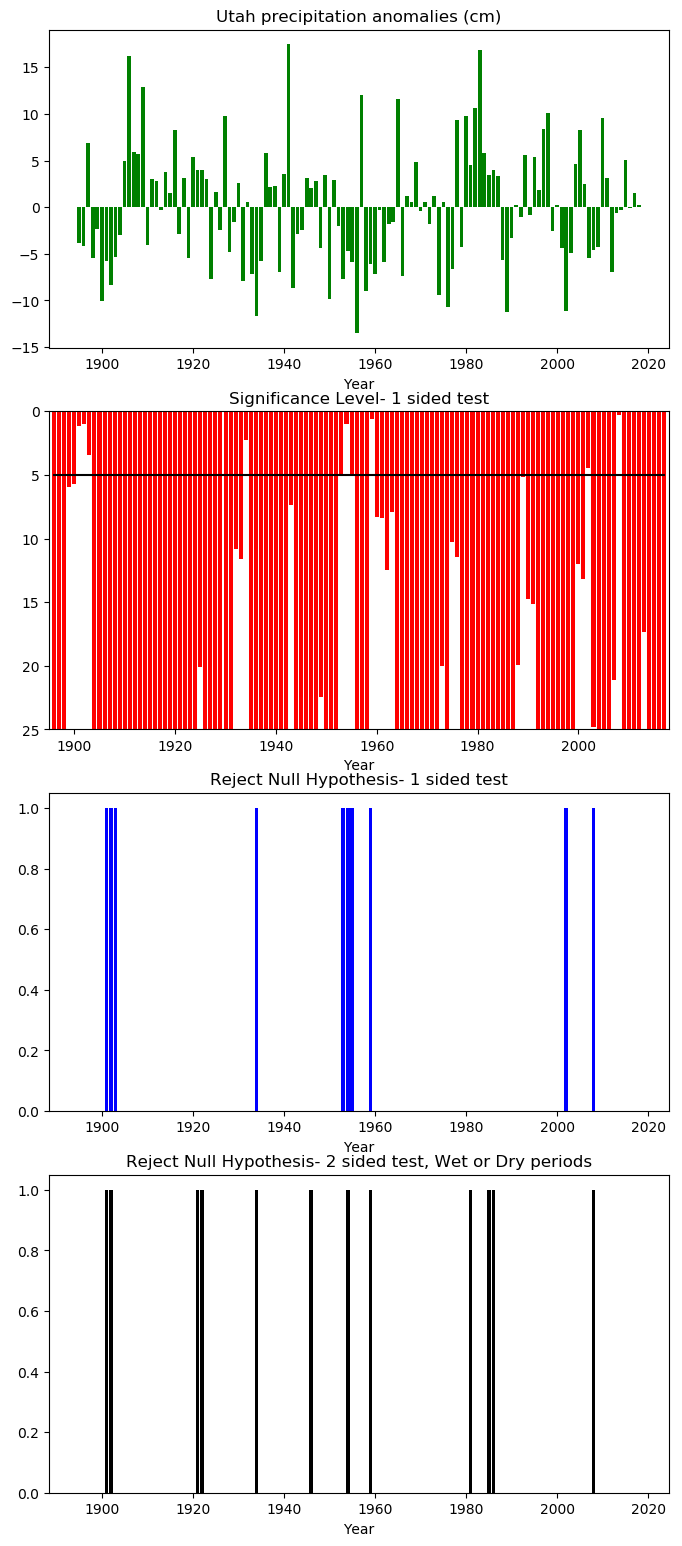

PyObject Text(0.5, 1.0, 'Reject Null Hypothesis- 2 sided test, Wet or Dry periods')

In [20]:
# Figure 3.18
h03_one = zeros(no_p)
p03_one = zeros(no_p)
h03_two = zeros(no_p)
p03_two = zeros(no_p)
# For one sided test, only asking about droughts
for iyr in p_yr[2]:p_yr[end-1]
    ii = iyr - 1894
    # Load valy with each 3 year sample
    valy = anomp[ii-1:ii+1]
    #ttest(values, mean for null hypoth, significance level, sidedness)::(y/n, pvalue)
    t = OneSampleTTest(valy)
    pl = pvalue(t, tail=:left)
    p03_one[ii] = pl * 100
    h03_one[ii] = ifelse(pl < 0.05, 1, 0)
    p2 = pvalue(t, tail=:both)
    p03_two[ii] = p2 * 100
    h03_two[ii] = ifelse(p2 < 0.05, 1, 0)
end
fig, (ax1, ax2, ax3, ax4) = subplots(4, figsize=(8, 19))
ax1[:bar](p_yr, anomp, color="g")
ax1[:set_xlabel]("Year")
ax1[:set_title]("Utah precipitation anomalies (cm)")

x1 = [p_yr[2], p_yr[end-1]]
y1 = [5, 5]
ax2[:bar](p_yr, p03_one, color="r")
ax2[:plot](x1, y1, "k")
ax2[:set_xlim](p_yr[1], p_yr[end])
ax2[:set_ylim](0, 25)
ax2[:invert_yaxis]()
ax2[:set_xlabel]("Year")
ax2[:set_title]("Significance Level- 1 sided test")

# Plot the 3yr periods for which the null hypothesis can be rejected with risk of 5%
ax3[:bar](p_yr, h03_one, color="b")
ax3[:set_xlabel]("Year")
ax3[:set_title]("Reject Null Hypothesis- 1 sided test")

# Repeat with 2-sided test
ax4[:bar](p_yr, h03_two, color="k")
ax4[:set_xlabel]("Year")
ax4[:set_title]("Reject Null Hypothesis- 2 sided test, Wet or Dry periods")

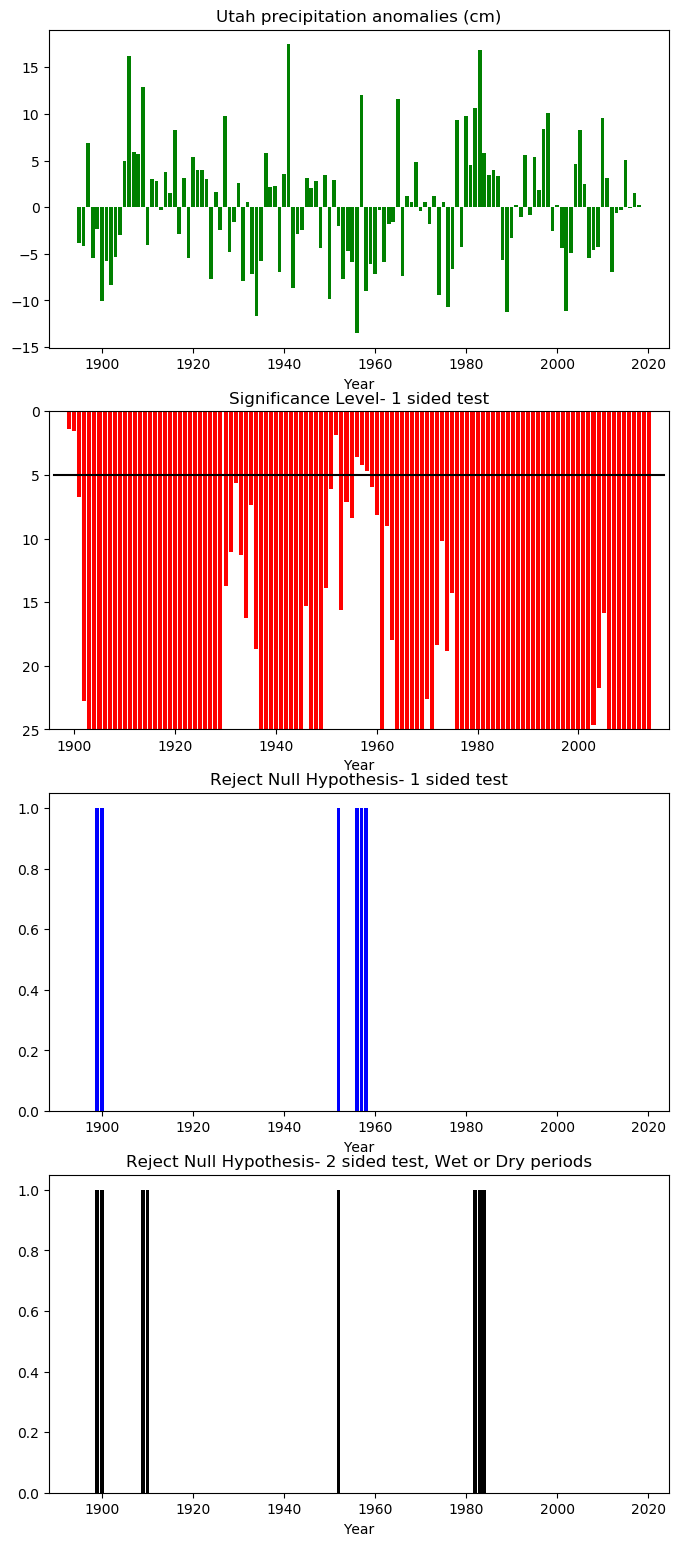

PyObject Text(0.5, 1.0, 'Reject Null Hypothesis- 2 sided test, Wet or Dry periods')

In [21]:
# Repeat with 9 year periods
# Figure 3.19
h09_one = zeros(no_p)
p09_one = zeros(no_p)
h09_two = zeros(no_p)
p09_two = zeros(no_p)
# For one sided test, only asking about droughts
for iyr in p_yr[5]:p_yr[end-4]
    ii = iyr - 1894
    # Load valy with each 3 year sample
    valy = anomp[ii-4:ii+4]
    #ttest(values, mean for null hypoth, significance level, sidedness)::(y/n, pvalue)
    t = OneSampleTTest(valy)
    pl = pvalue(t, tail=:left)
    p09_one[ii] = pl * 100
    h09_one[ii] = ifelse(pl < 0.05, 1, 0)
    p2 = pvalue(t, tail=:both)
    p09_two[ii] = p2 * 100
    h09_two[ii] = ifelse(p2 < 0.05, 1, 0)
end
fig, (ax1, ax2, ax3, ax4) = subplots(4, figsize=(8, 19))
ax1[:bar](p_yr, anomp, color="g")
ax1[:set_xlabel]("Year")
ax1[:set_title]("Utah precipitation anomalies (cm)")

x1 = [p_yr[2], p_yr[end-1]]
y1 = [5, 5]
ax2[:bar](p_yr, p09_one, color="r")
ax2[:plot](x1, y1, "k")
ax2[:set_xlim](p_yr[1], p_yr[end])
ax2[:set_ylim](0, 25)
ax2[:invert_yaxis]()
ax2[:set_xlabel]("Year")
ax2[:set_title]("Significance Level- 1 sided test")

# Plot the 3yr periods for which the null hypothesis can be rejected with risk of 5%
ax3[:bar](p_yr, h09_one, color="b")
ax3[:set_xlabel]("Year")
ax3[:set_title]("Reject Null Hypothesis- 1 sided test")

# Repeat with 2-sided test
ax4[:bar](p_yr, h09_two, color="k")
ax4[:set_xlabel]("Year")
ax4[:set_title]("Reject Null Hypothesis- 2 sided test, Wet or Dry periods")

A simple little comparison of how the t test values are distrubuted for a sample of 3 vs a sample of 30 years, which is almost the same as a gaussian. I.e. if your sample size is greater than 30 the t test values are distributed like a gaussian.

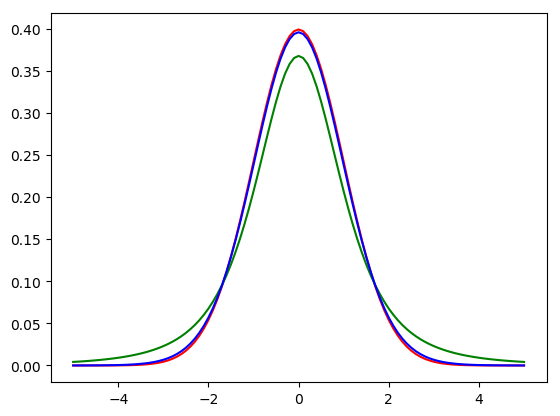

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7faa2a58fd68>

In [22]:
# Figure 3.20
x = -5:0.1:5
t3 = TDist(3)
t30 = TDist(30)
gauss = Normal(0, 1)
sample_3yr = pdf.(t3, x)
gaussian = pdf.(gauss, x)
sample_30yr = pdf.(t30, x)
plot(x, gaussian, "r")
plot(x, sample_3yr, "g")
plot(x, sample_30yr, "b")